In [3]:
torch.setdefaulttensortype('torch.FloatTensor')

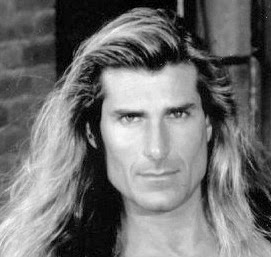

In [4]:
require 'image'
filter = image.gaussian(1)
filter:div(filter:sum())
input = image.convolve(image.fabio(), filter)
itorch.image(input)

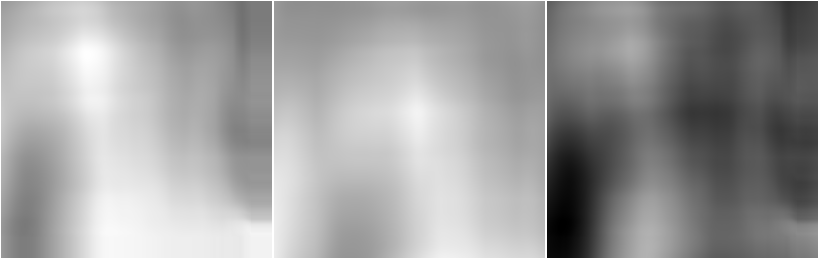

In [5]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'nn'
require 'IntegralSmartNorm'

refInt = IntegralSmartNorm(1, 2, input:size(1), input:size(2)):type(input:type())
refInt.exact = false
refInt.normalize = true

refRects = {{20, 20, 100, 100}, {-40, -40, 60, 60}}

for k = 1,2 do
    refInt.xMin[1][k], refInt.yMin[1][k], refInt.xMax[1][k], refInt.yMax[1][k] = table.unpack(refRects[k])
end
refInt:_reparametrize(false)

targetSeparate = refInt:forward(input)
target = targetSeparate[1] - targetSeparate[2]
itorch.image{targetSeparate[1], targetSeparate[2], target}

In [555]:
require 'WindowDebugger'

wDeb = WindowDebugger()

torch.manualSeed(668)

int = IntegralSmartNorm(1, 2, input:size(1), input:size(2)):type(input:type())
int.exact = false
int.normalize = true

conv = nn.SpatialConvolution(2, 1, 1,1,1,1)
conv.weight[1][1][1][1] = 1
conv.weight[1][2][1][1] = -1
conv.bias[1] = 0
conv.accGradParameters = function() end

net = nn.Sequential()
net:add(int)
net:add(conv)

crit = nn.MSECriterion():type(input:type())

params, gradParams = net:parameters()

-- int.xMin[1] = refRects[1][1]
-- int.yMin[1] = refRects[1][2]
-- int.xMax[1] = refRects[1][3]
-- int.yMax[1] = refRects[1][4]

-- int.xMin[2] = refRects[2][1]
-- int.yMin[2] = refRects[2][2]
-- int.xMax[2] = 150
-- int.yMax[2] = 150

-- params = torch.Tensor(params:storage(), 4, 2, 4)
-- gradParams = torch.Tensor(gradParams:storage(), 4, 2, 4)

In [556]:
require 'optim'

optimStates = {}

for k = 1,#params do
    optimStates[k] = {
        learningRate = k <= 4 and 10 or 1e-3,
        momentum = 0.9,
        nesterov = false,
        dampening = 0
    }
end

In [557]:
outputDir = 'Test-simple-Haar/2/'
os.execute('mkdir "' .. outputDir .. '" -p')
    
logger = optim.Logger(outputDir .. 'accuracy.log')
logger:setNames{'Loss'}
logger:style{'-'}

In [559]:
local diffGrad = false

for k = 1,50 do
    net:zeroGradParameters()
    net:forward(input)
    local loss = crit:forward(net.output, target)

    crit:backward(net.output, target)
    net:backward(input, crit.gradInput)

    for k = 1,#params do
        local function feval(x)
            return loss, gradParams[k]
        end
        optim.adam(feval, params[k], optimStates[k])
    end
    
    logger:add{loss}
    
    wDeb:add(int)
    
    logger:plot()
end

In [542]:
conv.gradWeight, conv.weight

(1,1,.,.) = 
  0

(1,2,.,.) = 
  0
[torch.FloatTensor of size 1x2x1x1]

(1,1,.,.) = 
  1

(1,2,.,.) = 
 -1
[torch.FloatTensor of size 1x2x1x1]



In [551]:
wDeb:exportVideo(outputDir .. 'int.avi', refRects)

### Plot the loss surface in `(xMax[2], yMax[2])` coordinates

In [ ]:
-- debug that issue about 0-s on outputOnes
intTest = IntegralSmartNorm(1, 240, 320):cuda()
inputTest = torch.range(1, 240*320):view(240,320):cuda()
intTest.exact = true

intTest.xMin[1], intTest.xMax[1], intTest.yMin[1], intTest.yMax[1] =
    -14.866806030273, -14.366806030273, 15.254815101624, 15.754815101624

intTest:forward(inputTest)
print(intTest.outputOnes:min())
print(intTest.outputOnes:max())
itorch.image(intTest.outputOnes)

In [ ]:
outData[2,1] = 
+intData[1,2] = 2
-intData[1,2] = 2
-intData[1,1] = 1
+intData[1,1] = 1
+1 * 0.9
+0 * 0
+1 * 0.1
+0 * 0
= 1

194 steps to do	


15	


30	


45	


60	


75	

90	


105	


120	


135	


150	


165	


180	


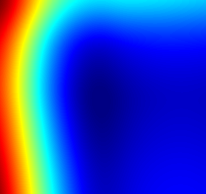

In [12]:
xMaxGrid = torch.range(int.xMin[2], int.xMin[2] + input:size(1)*0.85, 1)
yMaxGrid = torch.range(int.yMin[2], int.yMin[2] + input:size(2)*0.85, 1)
surface = torch.Tensor(xMaxGrid:nElement(), yMaxGrid:nElement()):random()

print(xMaxGrid:nElement() .. ' steps to make')

for i = 1,xMaxGrid:nElement() do
    for j = 1,yMaxGrid:nElement() do
        int.xMax[2] = xMaxGrid[i]
        int.yMax[2] = yMaxGrid[j]
        
        surface[{i,j}] = crit:forward(net:forward(input), target)
    end
    if i % 15 == 0 then
        print(i)
    end
end

function prepareForColorize(img)
    local retval = img:clone()
    retval:div(math.max(math.abs(img:max()), math.abs(img:min())))
    retval:add(-retval:min())
    retval:mul(255 / retval:max())
    retval:add(1e-2)
    assert(retval:min() > 0 and retval:min() < 2)
    assert(retval:max() > 0 and retval:max() < 256)
    
    return retval
end

itorch.image(image.y2jet(prepareForColorize(surface)))

In [5]:
sbInput = torch.CudaTensor(8, 240, 320):zero()
sbGO = torch.rand(8*40, 240, 320):cuda()
int = IntegralSmartNorm(40, 240, 320):cuda()
int.exact = true

In [7]:
int:forward(sbInput)
-- int:updateGradInput(sbInput, sbGO)
int:accGradParameters(sbInput, sbGO, 1)
cutorch.synchronize()

local repeats = 40
times = torch.FloatTensor(repeats)

for k = 1,repeats do
    int._backwardDone = false
    local timer = torch.Timer()
    
--     int:updateGradInput(sbInput, sbGO)
    int:accGradParameters(sbInput, sbGO, 1)
    cutorch.synchronize()
    
    timer:stop()
    times[k] = timer:time().real
end

print(times:mean() .. ' +/- ' .. 2.1 * times:std() .. ' seconds')

0.37490793466568 +/- 0.10651508556371 seconds	


## Gradcheck with reference

In [25]:
-- create the reference
if lfs.attributes('reference.t7') then
    error('Reference already exists')
end

reference = {}

for seed = 1,9 do
    torch.manualSeed(seed)
    input = torch.randn(40, 40)
    gradOutput = torch.randn(30, 40, 40)
    int = IntegralSmartNorm(30, 40, 40)
    int.exact = true
    params, gradParams = int:getParameters()
    gradParams:zero()

    int:forward(input)
    int:backward(input, gradOutput)
    
    reference[seed] = {
        input = input,
        gradOutput = gradOutput,
        output = int.output,
        gradInput = int.gradInput,
        params = params,
        gradParams = gradParams
    }
end

collectgarbage()
torch.save('reference.t7', reference)

In [4]:
-- tester
collectgarbage()
reference = torch.load('reference.t7')

for seed = 1,9 do
    int = IntegralSmartNorm(30, 40, 40):cuda()
    int.exact = true
    input = reference[seed].input:typeAs(int)
    gradOutput = reference[seed].gradOutput:typeAs(int)
    params, gradParams = int:getParameters()
    params:copy(reference[seed].params)
    gradParams:zero()

    int:forward(input)
    local err = (int.output:float() - reference[seed].output):norm(1) / int.output:nElement()
    if err > 1e-3 then
        print('Seed ' .. seed .. ', output, error is ' .. err)
    end
    
    int:backward(input, gradOutput)
    local err = (int.gradInput:float() - reference[seed].gradInput):norm(1) / int.gradInput:nElement()
    if err > 1e-3 then
        print('Seed ' .. seed .. ', gradInput, error is ' .. err)
    end
    local err = (gradParams:float() - reference[seed].gradParams):norm(1) / gradParams:nElement()
    if err > 1e-3 then
        print('Seed ' .. seed .. ', accGradParams, error is ' .. err)
    end
end

collectgarbage()